# Build a RAG agent with LangChain
## Overview
Q&A Chatbots are applications that can answer questions aout specific source information, These applications use a technique know as Retrieval Augmented Generation or RAG.

This tutorial will show how to build a simple Q&A application over an unstructured text data source.

## Concepts
- **Indexing**: a pipeline for ingesting data from a source and indexing it.
- **Retrieval and generation**: the actual RAG process, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.
## Preview
In this guide we'll build an app that answers questions about the website's content. The specific website we will use is the [Extrinsic Hallucinations in LLMs](https://lilianweng.github.io/posts/2024-07-07-hallucination/) blog post by Lilian Weng, which allow us to ask questions about the content of the post.

## Load env variables

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

## Setup

In [ ]:
pip install langchain langchain-text-splitters langchain-community bs4

### Components
We will need to select three components from LangChain's suite of integrations.
- Chat Model
- Embeddings Model
- Vector Store

#### Select Chat Model

In [19]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-3.5-turbo")

#### Select Embeddings Model

In [22]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### Select a Vector Store

In [23]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

## 1. Indexing
Indexing commonly works as follows:
1. **Load**: First we need to load our data. This is done with **Document Loaders**.
2. **Split**: **Text spliters** break large Documents into smaller chunks. This is useful both for indexing data and passing it into model, as large chunks are harder to search over and won't fit in a model's finit context window.
3. **Store**: We need somewhere to store and index our splits, so that they can be searched over late. This is often don using a VectorStore and Embeddings model.

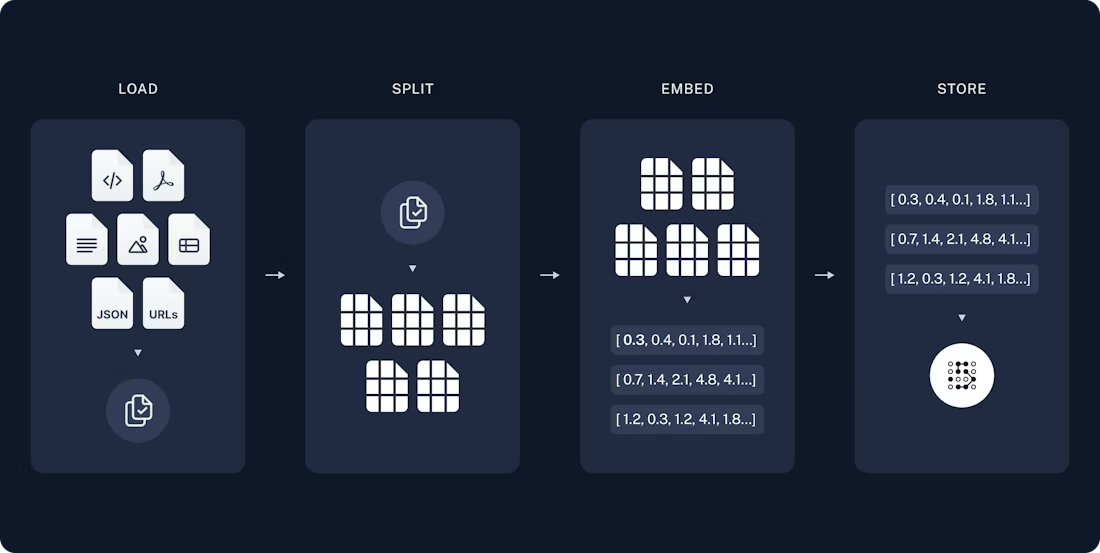

### Loading documents
We need to first load the blog post contents. In this case we'll use the **WebBaseLoader** which uses `urlib` to load HTML from web URLs and `BeautifulSoup` to parse it to text. We can customize the HTML -> text parsing by passing in parameters into the `BeautifulSoup` parser via `bs_kwargs`. In this case only HTML tags with class "post-content", "post-title", or "post-header" are relevant, so we'll remove all others.

In [10]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headersm and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2024-07-07-hallucination/",),
    bs_kwargs={"parse_only":bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 41845


### Splitting Documents
Our loaded document is over 42K characters which is too long to fit into context window of many models. To handle this we'll split the Document into chunks for embedding and vector storage. This should help us retrieve only the most relevant parts of the blog post at run time.
We'll use the **RecursiveCharacterTextSplitter**, which will recursively split the document using common separators like new lines until each chunk is the appropriate size.

In [16]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200,
    add_start_index = True,
)

all_splits = text_splitter.split_documents(docs)
print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 59 sub-documents.


### Storing documents
Now we need to index our text chunks so that we can search over them at runtime. The approach is to embed the contentx of each document split and insert these embeddings into a vector store. Given an input query, we can then use vector search to retrieve relevant documents.
We can embed and store all of our document splits in a single command using the vector store and embeddings model selected at the start of the tutorial.


In [24]:
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids[:3])

['c63fc3d3-018b-4a94-b7d3-ffe4de4e3622', '56514667-326a-4e23-be8b-c89317671ee9', '5adedc02-0a6b-4b23-844a-eea339a7946c']


## 2. Retrieval and Generation
RAG applications commonly work as follows:
1. **Retrieve**: Given a user input, relevant splits are retrieved from storage using a Retriever.
2. **Generate**: A model produces an answering using a prompt that includes both the question with the retrieved data.

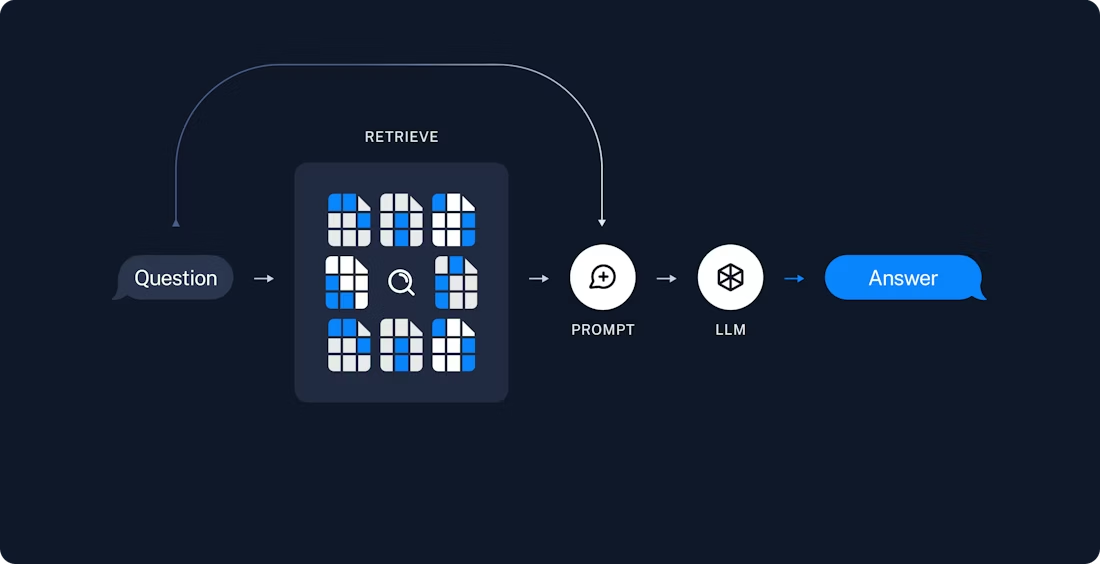

Now let's write the actual application logic. We want to create a simple applications that takes a user question, searchs for documents relevant to that question, passes the retrieved documents and initial question to a model, and returns an answer.

### RAG agents
One formulation of a RAG application is a as a simple agent with a tool retrieves information. We can assemble a minimal RAG agent by implementing a tool that wraps our vector store.

In [26]:
from langchain.tools import tool

@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve information to help answer to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [27]:
from langchain.agents import create_agent

tools = [retrieve_context]
# IF desired, specify custom instructions
prompt = (
    "You have acces to a tool that retrieves context from a blog post."
    "User the tool to help answer user queries."
)
agent = create_agent(model, tools, system_prompt=prompt)

In [28]:
query = (
    "What is the standard metod for Hallucination Detection?\n\n"
    "Once you get the answer, loop up common extensions of that method."
)

for event in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard metod for Hallucination Detection?

Once you get the answer, loop up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (call_0P7hhiYjhspZwScVRwGnK6N3)
 Call ID: call_0P7hhiYjhspZwScVRwGnK6N3
  Args:
    query: Standard method for Hallucination Detection
================================= Tool Message =================================
Name: retrieve_context

Source: {'source': 'https://lilianweng.github.io/posts/2024-07-07-hallucination/', 'start_index': 17046}
Content: Direct query asks the model to judge whether a generated reference exists. Indirect query instead asks for auxiliary details—who are the authors—for the generated reference; e.g. If we want to check "Is the following paper real?", we can check "Who are the author of the paper?" Hypothesis is that the likelihood of multiple gen